[View in Colaboratory](https://colab.research.google.com/github/dwu15/nuclei-detection-rcnn/blob/master/keras.ipynb)

In [2]:
import multiprocessing
multiprocessing.cpu_count()
!ls

datalab  kaggle18  logs  mask_rcnn_coco.h5


In [3]:
#@title Default title text
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!ls logs/dsb20180409T1527

events.out.tfevents.1523287652.7a90225d5c97  mask_rcnn_dsb_0002.h5
mask_rcnn_dsb_0001.h5			     mask_rcnn_dsb_0003.h5


In [4]:
#@title Import Data
import pandas as pd
train_labels = pd.read_csv('./develop/stage1_train_labels.csv')
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])

FileNotFoundError: ignored

# New Section

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1mu1PLm6RRR_GpXGcXR_F36yRTYCei4QL'
downloaded = drive.CreateFile({'id': file_id})




In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

csv_id = '1RWf9eM5vkYwO6dcWYTGlqUO5ipGtRC9'
downloaded2 = drive.CreateFile({'id': csv_id})
downloaded2.GetContentFile('test.csv')


train_labels = pd.read_csv('test.csv')

ApiRequestError: ignored

In [27]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving stage1_train_labels.csv to stage1_train_labels.csv
User uploaded file "stage1_train_labels.csv" with length 8127934 bytes


In [0]:
#@title Import Data
import pandas as pd
downloaded.GetContentFile('test.pkl')


In [0]:
train_img_df = pd.read_pickle('test.pkl')

train_labels = pd.read_csv('stage1_train_labels.csv')
train_data.shape
X_train = np.zeros((len(train_img_df['images']), img_width, img_height, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_img_df['images']), img_width, img_height, 1), dtype=np.bool)
for i,x in enumerate(train_img_df['images']):
  X_train[i] = x
  Y_train[i] = train_img_df['masks'][i]

In [8]:

import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
ix = random.randint(0, len(train_img_df))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

NameError: ignored

In [9]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda

def Unet(img_size):
    inputs = Input((img_size, img_size, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

    return model

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator


def generator(xtr, xval, ytr, yval, batch_size):
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_datagen.fit(xtr, seed=7)
    mask_datagen.fit(ytr, seed=7)
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=7)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=7)
    train_generator = zip(image_generator, mask_generator)

    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    image_datagen_val.fit(xval, seed=7)
    mask_datagen_val.fit(yval, seed=7)
    image_generator_val = image_datagen_val.flow(xval, batch_size=batch_size, seed=7)
    mask_generator_val = mask_datagen_val.flow(yval, batch_size=batch_size, seed=7)
    val_generator = zip(image_generator_val, mask_generator_val)
    return train_generator, val_generator

In [0]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.losses import binary_crossentropy


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [84]:
from sklearn.model_selection import train_test_split



img_size = 256
batch_size = 32


#X_train, Y_train, X_test, sizes_test = make_df(train_path, test_path, img_size)
xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
train_generator, val_generator = generator(xtr, xval, ytr, yval, batch_size)

model = Unet(img_size)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[mean_iou])
model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=50,
                    validation_data=val_generator, validation_steps=len(xval)/batch_size)

Epoch 1/50
101/100 [==============================] - 120s 1s/step - loss: -0.5726 - mean_iou: 0.6049 - val_loss: -0.7987 - val_mean_iou: 0.7297
Epoch 2/50
101/100 [==============================] - 115s 1s/step - loss: -0.7676 - mean_iou: 0.7586 - val_loss: -0.8238 - val_mean_iou: 0.7839
Epoch 3/50
101/100 [==============================] - 115s 1s/step - loss: -0.7844 - mean_iou: 0.7948 - val_loss: -0.8025 - val_mean_iou: 0.8062
Epoch 4/50
 47/100 [=============>................] - ETA: 59s - loss: -0.7863 - mean_iou: 0.8090 

101/100 [==============================] - 115s 1s/step - loss: -0.8046 - mean_iou: 0.8128 - val_loss: -0.8477 - val_mean_iou: 0.8198
Epoch 5/50
101/100 [==============================] - 114s 1s/step - loss: -0.8191 - mean_iou: 0.8249 - val_loss: -0.8384 - val_mean_iou: 0.8297
Epoch 6/50
101/100 [==============================] - 115s 1s/step - loss: -0.8271 - mean_iou: 0.8335 - val_loss: -0.8474 - val_mean_iou: 0.8371
Epoch 7/50
 63/100 [=================>............] - ETA: 42s - loss: -0.8075 - mean_iou: 0.8383

101/100 [==============================] - 114s 1s/step - loss: -0.8150 - mean_iou: 0.8392 - val_loss: -0.8481 - val_mean_iou: 0.8416
Epoch 8/50
101/100 [==============================] - 115s 1s/step - loss: -0.8128 - mean_iou: 0.8428 - val_loss: -0.8496 - val_mean_iou: 0.8450
Epoch 9/50
101/100 [==============================] - 114s 1s/step - loss: -0.8323 - mean_iou: 0.8467 - val_loss: -0.8451 - val_mean_iou: 0.8485
Epoch 10/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8347 - mean_iou: 0.8494

101/100 [==============================] - 113s 1s/step - loss: -0.8359 - mean_iou: 0.8499 - val_loss: -0.8485 - val_mean_iou: 0.8514
Epoch 11/50
101/100 [==============================] - 113s 1s/step - loss: -0.8316 - mean_iou: 0.8525 - val_loss: -0.8626 - val_mean_iou: 0.8537
Epoch 12/50
101/100 [==============================] - 114s 1s/step - loss: -0.8419 - mean_iou: 0.8549 - val_loss: -0.8508 - val_mean_iou: 0.8560
Epoch 13/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8272 - mean_iou: 0.8564

101/100 [==============================] - 114s 1s/step - loss: -0.8329 - mean_iou: 0.8567 - val_loss: -0.8426 - val_mean_iou: 0.8576
Epoch 14/50
101/100 [==============================] - 113s 1s/step - loss: -0.8200 - mean_iou: 0.8578 - val_loss: -0.8333 - val_mean_iou: 0.8586
Epoch 15/50
101/100 [==============================] - 114s 1s/step - loss: -0.8174 - mean_iou: 0.8587 - val_loss: -0.8649 - val_mean_iou: 0.8594
Epoch 16/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8323 - mean_iou: 0.8598

101/100 [==============================] - 112s 1s/step - loss: -0.8373 - mean_iou: 0.8600 - val_loss: -0.8560 - val_mean_iou: 0.8607
Epoch 17/50
101/100 [==============================] - 114s 1s/step - loss: -0.8479 - mean_iou: 0.8614 - val_loss: -0.8478 - val_mean_iou: 0.8621
Epoch 18/50
101/100 [==============================] - 114s 1s/step - loss: -0.8358 - mean_iou: 0.8625 - val_loss: -0.8647 - val_mean_iou: 0.8631
Epoch 19/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8228 - mean_iou: 0.8631

101/100 [==============================] - 113s 1s/step - loss: -0.8310 - mean_iou: 0.8633 - val_loss: -0.8604 - val_mean_iou: 0.8638
Epoch 20/50
101/100 [==============================] - 114s 1s/step - loss: -0.8411 - mean_iou: 0.8642 - val_loss: -0.8186 - val_mean_iou: 0.8647
Epoch 21/50
101/100 [==============================] - 114s 1s/step - loss: -0.8428 - mean_iou: 0.8651 - val_loss: -0.8611 - val_mean_iou: 0.8655
Epoch 22/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8448 - mean_iou: 0.8658

101/100 [==============================] - 114s 1s/step - loss: -0.8467 - mean_iou: 0.8659 - val_loss: -0.8648 - val_mean_iou: 0.8664
Epoch 23/50
101/100 [==============================] - 113s 1s/step - loss: -0.8361 - mean_iou: 0.8666 - val_loss: -0.8575 - val_mean_iou: 0.8670
Epoch 24/50
101/100 [==============================] - 115s 1s/step - loss: -0.8457 - mean_iou: 0.8673 - val_loss: -0.8646 - val_mean_iou: 0.8677
Epoch 25/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8543 - mean_iou: 0.8680

101/100 [==============================] - 114s 1s/step - loss: -0.8545 - mean_iou: 0.8681 - val_loss: -0.8605 - val_mean_iou: 0.8685
Epoch 26/50
101/100 [==============================] - 113s 1s/step - loss: -0.8432 - mean_iou: 0.8687 - val_loss: -0.8740 - val_mean_iou: 0.8691
Epoch 27/50
101/100 [==============================] - 114s 1s/step - loss: -0.8513 - mean_iou: 0.8694 - val_loss: -0.8634 - val_mean_iou: 0.8697
Epoch 28/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8554 - mean_iou: 0.8700

101/100 [==============================] - 113s 1s/step - loss: -0.8551 - mean_iou: 0.8701 - val_loss: -0.8666 - val_mean_iou: 0.8704
Epoch 29/50
101/100 [==============================] - 114s 1s/step - loss: -0.8561 - mean_iou: 0.8707 - val_loss: -0.8618 - val_mean_iou: 0.8710
Epoch 30/50
101/100 [==============================] - 114s 1s/step - loss: -0.8395 - mean_iou: 0.8712 - val_loss: -0.8521 - val_mean_iou: 0.8714
Epoch 31/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8470 - mean_iou: 0.8715

101/100 [==============================] - 113s 1s/step - loss: -0.8505 - mean_iou: 0.8716 - val_loss: -0.8647 - val_mean_iou: 0.8719
Epoch 32/50
101/100 [==============================] - 114s 1s/step - loss: -0.8387 - mean_iou: 0.8720 - val_loss: -0.8466 - val_mean_iou: 0.8722
Epoch 33/50
101/100 [==============================] - 114s 1s/step - loss: -0.8446 - mean_iou: 0.8723 - val_loss: -0.8552 - val_mean_iou: 0.8726
Epoch 34/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8444 - mean_iou: 0.8727

101/100 [==============================] - 114s 1s/step - loss: -0.8483 - mean_iou: 0.8727 - val_loss: -0.8676 - val_mean_iou: 0.8730
Epoch 35/50
101/100 [==============================] - 114s 1s/step - loss: -0.8426 - mean_iou: 0.8731 - val_loss: -0.8714 - val_mean_iou: 0.8733
Epoch 36/50
101/100 [==============================] - 115s 1s/step - loss: -0.8501 - mean_iou: 0.8735 - val_loss: -0.8663 - val_mean_iou: 0.8737
Epoch 37/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8525 - mean_iou: 0.8738

101/100 [==============================] - 114s 1s/step - loss: -0.8539 - mean_iou: 0.8739 - val_loss: -0.8610 - val_mean_iou: 0.8741
Epoch 38/50
101/100 [==============================] - 113s 1s/step - loss: -0.8470 - mean_iou: 0.8742 - val_loss: -0.8726 - val_mean_iou: 0.8744
Epoch 39/50
101/100 [==============================] - 113s 1s/step - loss: -0.8436 - mean_iou: 0.8744 - val_loss: -0.8670 - val_mean_iou: 0.8746
Epoch 40/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8599 - mean_iou: 0.8747

101/100 [==============================] - 114s 1s/step - loss: -0.8598 - mean_iou: 0.8748 - val_loss: -0.8732 - val_mean_iou: 0.8750
Epoch 41/50
101/100 [==============================] - 113s 1s/step - loss: -0.8610 - mean_iou: 0.8752 - val_loss: -0.8722 - val_mean_iou: 0.8754
Epoch 42/50
101/100 [==============================] - 113s 1s/step - loss: -0.8604 - mean_iou: 0.8756 - val_loss: -0.8561 - val_mean_iou: 0.8758
Epoch 43/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8561 - mean_iou: 0.8759

101/100 [==============================] - 113s 1s/step - loss: -0.8564 - mean_iou: 0.8760 - val_loss: -0.8637 - val_mean_iou: 0.8761
Epoch 44/50
101/100 [==============================] - 113s 1s/step - loss: -0.8599 - mean_iou: 0.8763 - val_loss: -0.8556 - val_mean_iou: 0.8765
Epoch 45/50
101/100 [==============================] - 113s 1s/step - loss: -0.8519 - mean_iou: 0.8766 - val_loss: -0.8687 - val_mean_iou: 0.8767
Epoch 46/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8471 - mean_iou: 0.8768

101/100 [==============================] - 113s 1s/step - loss: -0.8516 - mean_iou: 0.8768 - val_loss: -0.8671 - val_mean_iou: 0.8770
Epoch 47/50
101/100 [==============================] - 113s 1s/step - loss: -0.8617 - mean_iou: 0.8771 - val_loss: -0.8659 - val_mean_iou: 0.8773
Epoch 48/50
101/100 [==============================] - 113s 1s/step - loss: -0.8614 - mean_iou: 0.8775 - val_loss: -0.8687 - val_mean_iou: 0.8776
Epoch 49/50
 65/100 [==================>...........] - ETA: 39s - loss: -0.8562 - mean_iou: 0.8777

101/100 [==============================] - 113s 1s/step - loss: -0.8586 - mean_iou: 0.8777 - val_loss: -0.8644 - val_mean_iou: 0.8779
Epoch 50/50
101/100 [==============================] - 113s 1s/step - loss: -0.8602 - mean_iou: 0.8780 - val_loss: -0.8757 - val_mean_iou: 0.8781


In [86]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [114]:
#@title Test data upload
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test_data.h5 to test_data (2).h5
User uploaded file "test_data.h5" with length 38915208 bytes


In [0]:
from google.colab import files
files.download("model.h5")

In [130]:
!pip install tables
test_img_df = pd.read_hdf("test_data (2).h5",'table')
X_test = np.zeros((len(test_img_df['images']), 256, 256, 3), dtype=np.uint8)
sizes_test = []
for i, id_ in enumerate(test_img_df['images']):
    sizes_test.append([id_.shape[0], id_.shape[1]])
    
    X_test[i] = cv2.resize(id_,(256,256))

In [0]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [131]:
preds_test = model.predict(X_test, verbose=1)
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(preds_test[i], 
                                       (sizes_test[i][1], sizes_test[i][0])))

preds_test_t = (preds_test > 0.5).astype(np.uint8)
new_test_ids = []
rles = []
for n, id_ in enumerate(test_img_df["ImageID"]):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
        
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub.csv', index=False)

65/65 [==============================] - 1s 11ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


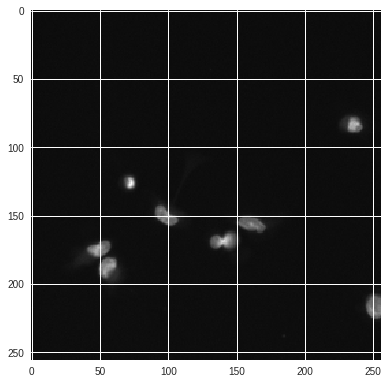

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


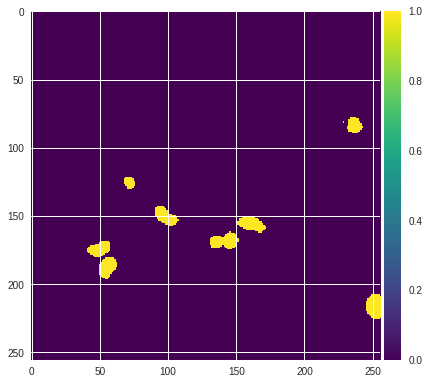

In [132]:
ix = 15
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [0]:
from google.colab import files
files.download("sub.csv")

In [2]:
!ls -la

total 36
drwxr-xr-x 1 root root 4096 Apr  4 03:16 .
drwxr-xr-x 1 root root 4096 Apr  4 03:14 ..
drwx------ 4 root root 4096 Apr  4 03:16 .cache
drwxr-xr-x 3 root root 4096 Apr  4 03:16 .config
drwxr-xr-x 1 root root 4096 Mar 13 21:48 datalab
drwxr-xr-x 4 root root 4096 Apr  4 03:15 .forever
drwxr-xr-x 5 root root 4096 Apr  4 03:16 .ipython
drwx------ 3 root root 4096 Apr  4 03:15 .local
-rw------- 1 root root 1024 Apr  4 03:15 .rnd
